# Homework 3: Intoduction to Data Science

## Due Tuesday, June 5, start of class

### Jake Pitkin

In [229]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import time
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import math

### 1. Scrape Github Repository List and Repository Information using BeautifulSoup

### Task 1.2 Download the website

In [49]:
# Download the first 10 pages of the highly starred git repos
for i in range(1, 11):
    url = "https://github.com/search?o=desc&p=" + str(i) + "&q=stars%3A%3E1&s=stars&type=Repositories"
    # here we actually access the website
    with urllib.request.urlopen(url) as response:
        html = response.read()
        html = html.decode('utf-8')

    # save the file
    with open("git_pages/page_" + str(i) + ".html", 'w') as new_file:
        new_file.write(html)
    time.sleep(10)

# Read 10 pages from disk and create soup objects
pages = []
for i in range(1, 11):
    page = BeautifulSoup(open("git_pages/page_" + str(i) + ".html"), "html.parser")
    pages.append(page)
    
# Extract the repository links
repo_links = []
for i in range(10):
    for repo_link in pages[i].select(".v-align-middle"):
        try:
            repo_links.append("https://github.com/" + repo_link['href'])
        except:
            pass

# Download each repository page
for i, repo_link in enumerate(repo_links):
    # here we actually access the website
    with urllib.request.urlopen(repo_link) as response:
        html = response.read()
        html = html.decode('utf-8')

    # save the file
    with open("repo_pages/repo_" + str(i) + ".html", 'w') as new_file:
        new_file.write(html)
    time.sleep(10) 

### 1.3 Extract Data

In [175]:
# Extract the repository links from saved html files
pages = []
for i in range(1, 11):
    page = BeautifulSoup(open("git_pages/page_" + str(i) + ".html"), "html.parser")
    pages.append(page)
repo_links = []
for i in range(10):
    for repo_link in pages[i].select(".v-align-middle"):
        try:
            repo_links.append("https://github.com/" + repo_link['href'])
        except:
            pass

# Read repo pages from disk and create soup objects
repo_pages = []
for i in range(100):
    page = BeautifulSoup(open("repo_pages/repo_" + str(i) + ".html"), "html.parser")
    repo_pages.append(page)

# Create an entry for each repository
project_info = pd.DataFrame(columns=['name', 'url', 'commits', 'forks', 'contributors', 'stars', 'issues', 'len_readme'])

for index, repo_page in enumerate(repo_pages):
    try:
        url = repo_links[index]
        name = url.split('/')[-1]
        commits = repo_page.select(".commits")[0].select(".num")[0].get_text().replace(" ", "").replace("\n", "")
        forks = repo_page.select(".social-count")[2].get_text().replace(" ", "").replace("\n", "")
        contributors = repo_page.select(".numbers-summary")[0].select(".num")[3].get_text().replace(" ", "").replace("\n", "")
        stars = repo_page.select(".social-count")[1].get_text().replace(" ", "").replace("\n", "")
        issues = repo_page.select(".Counter")[0].get_text().replace(" ", "").replace("\n", "")
        len_readme = len(repo_page.select("#readme")[0].get_text())
    except:
        print("fail")
        continue
    project_info = project_info.append({'name':name, 'url':url, 'commits':commits, 'forks':forks,
                                        'contributors':contributors, 'stars':stars, 'issues':issues, 
                                        'len_readme':len_readme}, ignore_index=True)

# Save dataframe to disk
project_info.to_csv("project_info.csv", sep=',', index=False)

### 2. Use linear regression to analyze the Github repository data

### 2.1 Reformat the data into useful datatypes

In [176]:
# Load in the csv
df = pd.read_csv("project_info.csv", sep=',')

# Check the data types
print("Original data types:")
print(df.dtypes)
print()

# Correct the data types
df.set_value(15, 'contributors', "15000")
df['contributors'] = df['contributors'].fillna("1")
df['commits'] = df['commits'].str.replace(',','').astype(int)
df['forks'] = df['forks'].str.replace(',','').astype(int)
df['contributors'] = df['contributors'].str.replace(',','').astype(int)
df['stars'] = df['stars'].str.replace(',','').astype(int)
df['issues'] = df['issues'].str.replace(',','').astype(int)

# Check the corrected data types
print("Corrected data types:")
print(df.dtypes)
print()

Original data types:
name            object
url             object
commits         object
forks           object
contributors    object
stars           object
issues          object
len_readme       int64
dtype: object

Corrected data types:
name            object
url             object
commits          int64
forks            int64
contributors     int64
stars            int64
issues           int64
len_readme       int64
dtype: object



### Task 2.2 Describe the data

Overview of the data:
             commits         forks  contributors          stars       issues  \
count     100.000000    100.000000    100.000000     100.000000   100.000000   
mean    18391.430000  10419.650000    740.040000   46001.390000   617.010000   
std     76180.907275   9407.312263   1657.211367   31227.089001  1005.990657   
min         2.000000    726.000000      1.000000   28426.000000     0.000000   
25%      1159.000000   5131.000000    133.500000   32425.250000    36.500000   
50%      3869.000000   8112.000000    319.000000   36024.500000   217.500000   
75%     12019.250000  12987.500000    776.250000   49064.750000   601.750000   
max    753972.000000  63614.000000  15000.000000  292257.000000  4730.000000   

          len_readme  
count     100.000000  
mean    12215.880000  
std     22363.800333  
min       349.000000  
25%      1910.500000  
50%      3518.500000  
75%     10129.000000  
max    120244.000000  



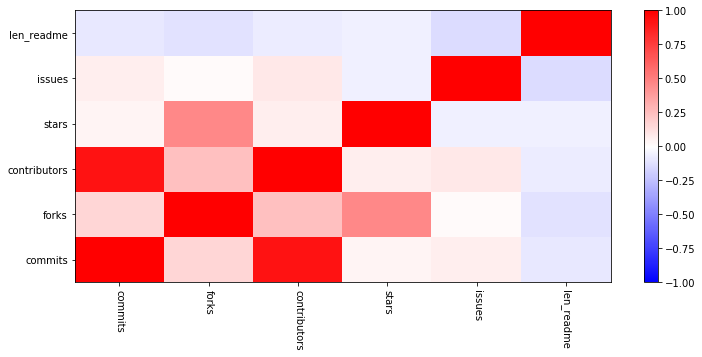

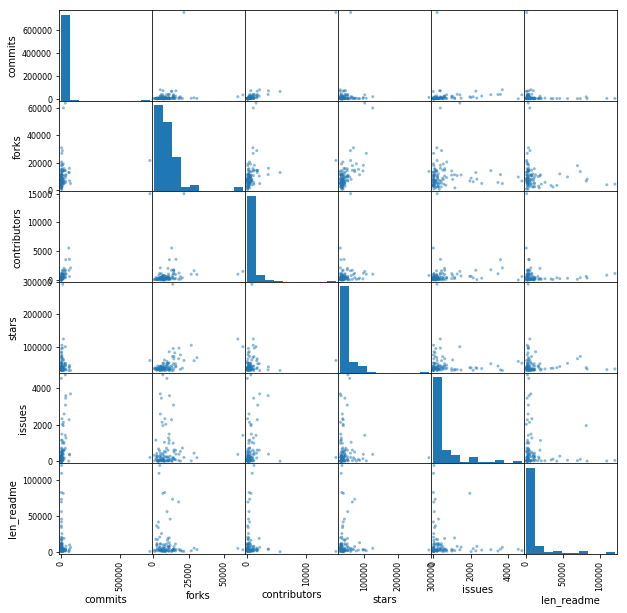

In [185]:
# Overview of the data
print("Overview of the data:")
print(df.describe())
print()

# Correlation matrix heat map
%matplotlib inline
plt.figure(figsize=(12, 5))
heatmap = plt.pcolor(df.corr(), cmap=plt.cm.bwr, vmin=-1, vmax=1)
labels = ["commits", "forks", "contributors", "stars", "issues", "len_readme"]
plt.xticks(np.arange(0.5, 6, step=1), labels, rotation=270)
plt.yticks(np.arange(0.5, 6, step=1), labels)
plt.colorbar(heatmap);

# Scatterplot matrix of the correlations
pd.plotting.scatter_matrix(df, figsize=(10, 10), diagonal='hist');

### 2.3 Linear regression

In [199]:
multi_regression = sm.ols(formula="stars ~ forks + contributors + issues + len_readme", data=df).fit()
print(multi_regression.summary())

multi_regression_2 = sm.ols(formula="stars ~ forks + commits + contributors", data=df).fit()
print(multi_regression_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.835
Date:                Wed, 30 May 2018   Prob (F-statistic):           7.04e-05
Time:                        00:02:00   Log-Likelihood:                -1163.6
No. Observations:                 100   AIC:                             2337.
Df Residuals:                      95   BIC:                             2350.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.158e+04   5032.669      6.276   

## Part 1: MNIST handwritten digits

### Task 1.1: Classification with Support Vector Machines (SVM)

In [309]:
# Train a SVM model and evaluate
digits = load_digits()
X = scale(digits.data)
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
classifier = svm.SVC(C=100, kernel='rbf')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(metrics.classification_report(y_test, predictions))
print(metrics.confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       130
          1       0.95      0.94      0.94       149
          2       0.95      0.94      0.95       142
          3       0.98      0.93      0.95       147
          4       1.00      0.92      0.96       152
          5       0.97      0.96      0.97       147
          6       0.99      0.99      0.99       146
          7       0.87      0.99      0.93       140
          8       0.88      0.95      0.91       133
          9       0.96      0.92      0.94       152

avg / total       0.95      0.95      0.95      1438

[[130   0   0   0   0   0   0   0   0   0]
 [  0 140   4   0   0   0   0   1   4   0]
 [  0   1 134   0   0   0   0   2   5   0]
 [  0   0   3 136   0   0   0   3   4   1]
 [  0   0   0   0 140   0   0  12   0   0]
 [  0   0   0   0   0 141   1   0   1   4]
 [  0   1   0   0   0   0 144   0   1   0]
 [  0   0   0   0   0   0   0 139   0   1]
 [  0   4   0   1

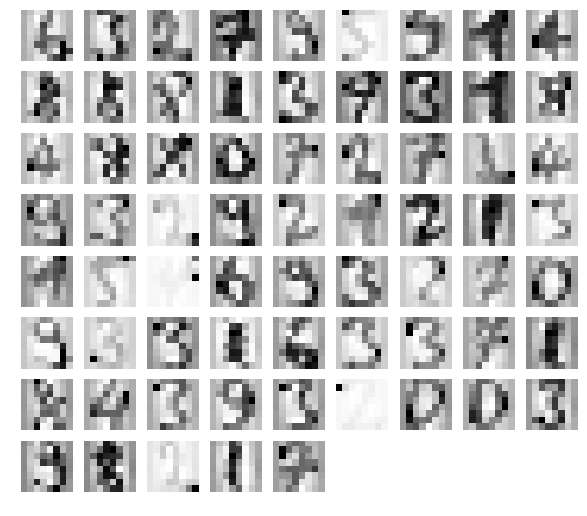

In [240]:
# Show the misclassified test instances
misclassified_indices = np.where(y_test != predictions)[0]
dim = math.ceil(math.sqrt(len(misclassified_indices)))
plt.figure(figsize= (10, 10))
for count, index in enumerate(misclassified_indices):    
    plt.subplot(dim, dim, count+1)
    plt.imshow(np.reshape(X[index,:],(8,8)), cmap='Greys',interpolation='nearest')
    plt.axis('off')
plt.show()

In [302]:
# Cross validation
best_score = 0
best_c = 0
digits = load_digits()
X = scale(digits.data)
y = digits.target
#for c in np.arange(1, 500, step=5):
for c in range(1, 500):
    classifer = svm.SVC(C=c, kernel='rbf')
    score = cross_val_score(classifer, X, y, cv=3).mean()
    if score > best_score:
        best_score = score
        best_c = c
print("Best C:", best_c, "Accuracy:", best_score)

Best C: 2 Accuracy: 0.960469539084


In [303]:
#Unscaled data
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
classifier = svm.SVC(C=2, kernel='rbf')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.09      1.00      0.17       130
          1       1.00      0.12      0.22       149
          2       1.00      0.01      0.03       142
          3       0.00      0.00      0.00       147
          4       0.00      0.00      0.00       152
          5       0.00      0.00      0.00       147
          6       1.00      0.05      0.09       146
          7       1.00      0.09      0.16       140
          8       1.00      0.01      0.01       133
          9       0.00      0.00      0.00       152

avg / total       0.50      0.12      0.07      1438



/Users/jsp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Task 1.2: Prediction with k-nearest neighbors

In [269]:
# Train a k-NN model and evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(metrics.classification_report(y_test, predictions))
print(metrics.confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98       130
          1       0.89      0.98      0.93       149
          2       0.98      0.90      0.94       142
          3       0.91      0.92      0.91       147
          4       0.99      0.99      0.99       152
          5       0.95      0.95      0.95       147
          6       0.99      0.99      0.99       146
          7       0.88      1.00      0.93       140
          8       0.89      0.88      0.89       133
          9       0.95      0.80      0.87       152

avg / total       0.94      0.94      0.94      1438

[[130   0   0   0   0   0   0   0   0   0]
 [  0 146   0   1   1   1   0   0   0   0]
 [  2   3 128   0   0   0   0   2   7   0]
 [  0   0   0 135   0   2   0   6   3   1]
 [  0   0   0   0 150   0   0   2   0   0]
 [  0   0   0   3   1 139   1   0   0   3]
 [  0   1   0   0   0   0 144   0   1   0]
 [  0   0   0   0   0   0   0 140   0   0]
 [  0   6   2   4

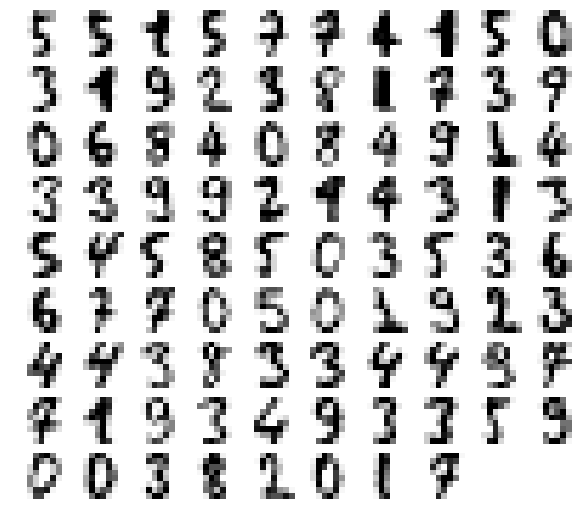

In [270]:
# Show the misclassified test instances
misclassified_indices = np.where(y_test != predictions)[0]
dim = math.ceil(math.sqrt(len(misclassified_indices)))
plt.figure(figsize= (10, 10))
for count, index in enumerate(misclassified_indices):    
    plt.subplot(dim, dim, count+1)
    plt.imshow(np.reshape(X[index,:],(8,8)), cmap='Greys',interpolation='nearest')
    plt.axis('off')
plt.show()

In [291]:
# Cross validation
best_score = 0
best_k = 0
digits = load_digits()
X = scale(digits.data)
y = digits.target
for k in np.arange(1, 50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classifier, X, y, cv=10).mean()
    if score > best_score:
        best_score = score
        best_k = k
print("Best k:", best_k, "Accuracy:", best_score)

Best k: 3 Accuracy: 0.962214718399


In [293]:
#Unscaled data
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       130
          1       0.93      0.97      0.95       149
          2       0.98      0.92      0.95       142
          3       0.94      0.93      0.94       147
          4       0.96      0.99      0.97       152
          5       0.96      0.96      0.96       147
          6       0.99      0.99      0.99       146
          7       0.93      1.00      0.97       140
          8       0.92      0.91      0.92       133
          9       0.96      0.88      0.92       152

avg / total       0.96      0.95      0.95      1438

